# Introduccion a ficheros Fits

## Carga de datos

Un fichero .fits es un fichero binario por lo que no se puede abrir con un editor de texto. En el, la información se guarda en secciones, que llamaremos de aquí en adelante "extensiones". Cada extensión, a su vez, tiene dos compartimentos: los datos y la cabecera.

__Los datos:__ pueden venir en dos tipos de formato: imagen o tabla.

* Imagen: Es simplemente un array numerico, que puede ser 1D (ejm: un espectro), 2D (ejm: una imagen) o 3D (ejm: un cubo). en este proyecto no los necesitaremos.
* Tabla: Aquí hay filas y columnas y se pueden interpretar como dataframes de pandas.

__La cabecera:__ Son los metadatos, informacion sobre los datos. Vienen en forma de registros, donde cada registro tiene 3 partes: etiqueta, valor, comentario. La etiqueta se usa para acceder al valor y el comentario te describe qué se está guardando ahí. Puede ser cualquier tipo de información (desde el astronomo que tomó los datos, hasta el ruido de lectura de la ccd, el día de la observación). La estructura de la cabecera es equivalente a la de los diccionarios de python.

Aquí hay dos enlaces que explican como trabajar con ficheros .fits en python:

* http://docs.astropy.org/en/stable/io/fits/ 

* http://www.astropy.org/astropy-tutorials/FITS-images.html

Hasta aquí, todo es general. Para el caso concreto de este proyecto, aquí hay un fichero tipo de los que se usarían:

* https://dr14.sdss.org/optical/spectrum/view?plate=285&mjd=51930&fiberid=184

Si se observa su estructura interna, se puede ver que está hecho de varias extensiones, todas de tipo tabla.


In [3]:
# Abrimos el archivo fit mediante utilizando la librería astropy con los siguientes comandos
from astropy.io import fits
import pandas as pd

# fits_image_filename = fits.util.get_testdata_filepath('spec-0268-51633-0001.fits')
fplate = '0523'
fmjd = '52026'
ffiber = '0003'
hdul = fits.open('spec-'+ fplate + '-' + fmjd + '-' + ffiber + '.fits')

## El modelo de datos

Vamos a describir el modelo de datos que alberga cada uno de los archivos fit que utilizaremos en este proyecto.<br>
Los archivos fits vienen identificados con un nombre del estilo
    __spec-PLATE-MJD-FIBER.fits__

siendo:
* **Plate :** Placa, plancha o conjunto de datos al que hace referencia el fichero. Cada plancha contiene 1000 objetos  observados (variaciones de MJD y FIBER). Cada uno de ellos nos muestra valores de luminancia sobre el espectro completo de anchos de banda (entre 3600 y 10000 Amstrong).
* **MJD :** Representacion de la fecha de la observacion en modo Juliana modificado (numero de día transcurridos desde el 17 de noviembre de 1858).
* **FIBER :** Un entero que representa el número de la fibra utilizada en la observacion. En el DR8 este parametro oscila entre el 1 y el 640. Cada placa tiene un agujero situado en el punto dónde se va a realizar la observación y dónde se enchufa un extremo de la fibra. El otro extremo recoge la luz hacia el espetrografo. 

Solamente una combinacion de PLATE + MJD + FIBERID puede representar una unica observación sobre un objeto único de manera univoca.

Otros parámetros que podemos encontrar son:
* **RUN2D:** Parámetro entero que indica la versión de la extracción del desplazamiento al rojo encontrado. Para DR8 puede tener tres valores: 26 proveniente del DR7, 103 especifico para clusters de estrellas y 104 para las placas de SEGUE-2
* **RUNSSPP:** Parámetro entero que indica la versión de Pipeline SEGUE utilizado.

Para el caso concreto que nos ocupa hara falta la siguiente información:
* **Dato PLATE:** Placa de la observación y que se encuentra en el campo PLATEID de la cabecera de la extension 0 (hdul[0]['PLATEID'])
* **Dato MJD:** Fecha Julianae de la observación y que se encuentra en el campo MJD de la cabecera de la extension 0 (hdul[0]['MJD'])
* **Dato FIBER:** Fibra de la observación y que se encuentra en el campo FIBERID de la cabecera de la extension 0 (hdul[0]['FIBERID'])
* **Dato Desplazamiento al Rojo (Redshift):** Dato común a todo el espectro y que se encuentra en el campo 64 de la extension 2 (hdul[2].data['Z']).
* **Columna Flux:** Columna que indica el valor de intensidad de pixel en una frecuencia del espectro. Se encuentra en el campo 1 de la data de la extension 1 (hdul[1].data['FLUX']). 
* **Columna LOGLAM:** Columna que indica el logaritmo en base 10de la longitud de onda en Amstrongs (eje X del espectro). Este valor será necesario corregirlo con el redshift. Se encuentra en el campo 1 de la data de la extension 1 (hdul[1].data['LOGLAM']).

Para ver la referencia completa de los campos de cada extension consulta la siguiente información:
* **Modelo de datos de extension 0 :** https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spPlate.html
* **Modelo de datos de extension 1:** https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/spectra/PLATE4/spec.html
* **Modelo de datos de extension 2 :** https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html
* **Modelo de datos de extension 3:** https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/RUN1D/spZline.html

En caso de ficheros grandes, se puede utilizar la librería fitsio que solo lee los campos necesarios<br>
``` python
import fitsio
columns = ['PLATE', 'MJD', 'FIBERID', 'Z', 'ZWARNING', 'Z_ERR']
d = fitsio.read('spAll-v5_5_12.fits', columns=columns)```


In [4]:
# Analizamos la estructura del archivo
hdul.info()

Filename: spec-0523-52026-0003.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     139   ()      
  1  COADD         1 BinTableHDU     26   3826R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPECOBJ       1 BinTableHDU    262   1R x 126C   [6A, 4A, 16A, 23A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 19A, I, 3A, 3A, 1A, J, D, D, D, E, E, 19A, 8A, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 10A, E, E, E, E, E, E, E, E, J, E, E, J, 1A, 1A, E, E, J, J, 1A, 5E, 5E]   
  3  SPZLINE       1 BinTableHDU     48   29R x 19C   [J, J, J, 13A, D, E, E, E, E, E, E, E, E, E, E, J, J, E, E]   


Cada archivo hduList tiene una serie de secuencias de datos (cada uno de los índices) y a su vez cada uno de ellos tiene una cabecera y unos datos a los que se accede mediante los atributos `.header` y `.data`. Los tipos Primary corresponden a Metadatos y los tipos Image a imagenes.

In [5]:
# Para el archivo spec-0285-51930-0184.fits Vamos a mostrar los elementos identificados que serán necesarios
# PLATE
plate = hdul[0].header['PLATEID']
print("Plate =", plate)

# MJD
mjd = hdul[0].header['MJD']
print("MJD =",mjd)

# FIBER
fiber = hdul[0].header['FIBERID']
print("FIBER =", fiber)

# Aunque se nos indicó ZOFFSET, Z puede ser el factor redshift buscado
z = hdul[2].data['Z'][0]
print("Z =", z) 

# FLUX
flux = hdul[1].data['FLUX']
print("FLUX COLUMN = ", flux)

# LOGLAM
loglam = hdul[1].data['LOGLAM']
print("LOGLAM COLUMN = ", loglam)

Plate = 523
MJD = 52026
FIBER = 3
Z = 0.0805998
FLUX COLUMN =  [ 0.9746093  3.6390533  4.1464005 ... 12.175927   9.677477  10.243458 ]
LOGLAM COLUMN =  [3.582  3.5821 3.5822 ... 3.9643 3.9644 3.9645]


## Líneas de Absorción y de Emisión

* **Lineas de absorción:** Se producen principalmente en determinadas frecuencias debido a los átomos en las atmósferas de las estrellas de una galaxia o a gas frío en el medio interestelar que absorven determinadas longitudes de ondas.Implica una galaxia de mucha edad con estrellas viejas y de forma eliptica o espiral.

* **Lineas de emisión:** Se producen debido a gas ionizado y caliente que irradia a determinadas frecuencias.Galaxia joven con estrallas jovenes en forma de disco o irregular.

Las líneas típica de referencia en cualquier espectro son las siguientes:
<img src = "LineasTipicas.PNG">

La detección de las líneas de absorción y emisión, junto con presencia en el espectro nos ayuda a saber el desplazamiento del mismo comparándo su frecuencia actual con la frecuencia típica. Además nos permite saber a qué distancia se encuentran.

## Corrección del Redshift
Este fenómeno se produce cuando observamos una fuente de luz distante y está en movimiento, alejándose. Durante el camino, las ondas electromagnéticas tienden a aumentar su longitud de onda y por lo tanto a disminuir su frecuencia. Esto es debido a que el universo está en expansión y por lo tanto el espacio-tiempo se estrecha, con lo que parece que se aleja más rápido en el espectro de la [luz visible](https://es.wikipedia.org/wiki/Espectro_visible#/media/Archivo:Electromagnetic_spectrum-es.svg). Las frecuencias más baja corresponde a la luz roja, de ahí su nombre (desplazamiento hacia el rojo).

El redshift se define como la diferencia relativa entre las longitudes de onda (o frecuencias) observadas y emitidas de un objeto. __En astronomía, es habitual referirse a este cambio utilizando una magnitud adimensional llamada Z.__ Si lambda representa la longitud de onda (o f la frecuencia) entonces z se define por las ecuaciones:
<img src = "formula1.png">

por lo tanto, despejando la variable lambda emitida tenemos que:
<img src = "formula2.png">

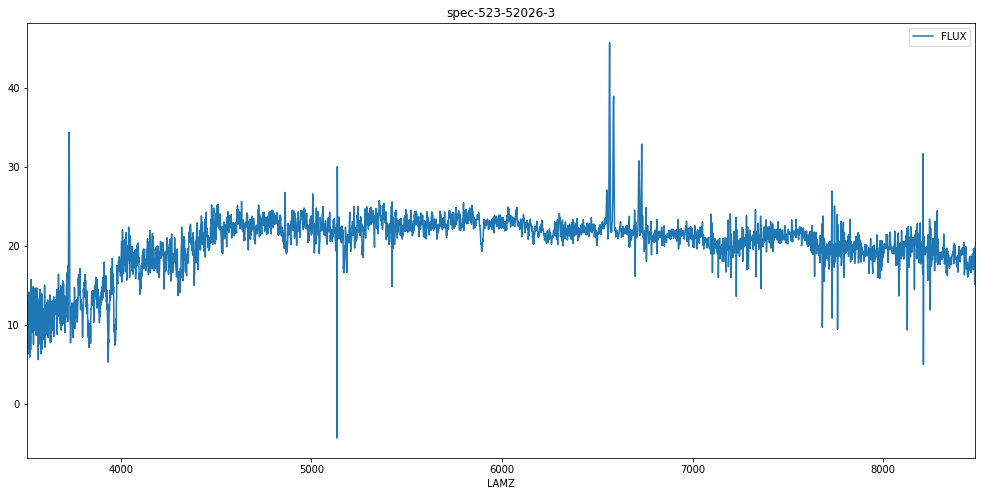

,Plate,MJD,FIBER,Z,FLUX,LOGLAM,LAM,LAMZ
0,473,51929,494,0.086619,9.835646,3.5810,3810.659021,3506.895341
1,473,51929,494,0.086619,6.724313,3.5811,3811.535658,3507.702098
2,473,51929,494,0.086619,8.904343,3.5812,3812.412496,3508.509040
3,473,51929,494,0.086619,12.580143,3.5813,3813.291630,3509.318095
4,473,51929,494,0.086619,7.470976,3.5814,3814.168873,3510.125409


In [6]:
# Dibujamos el espectro resultante
import matplotlib.pyplot as plt

def cargarFit(plate, mjd, fiber):

    url = 'https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=' + str(plate) + '&mjd=' + str(mjd) + '&fiberid=' + str(fiber)
    hdul = fits.open(url, cache=False)
    
    z = hdul[2].data['Z'][0]
    flux = hdul[1].data['FLUX']
    loglam = hdul[1].data['LOGLAM']

    df = pd.DataFrame(columns=['Plate', 'MJD', 'FIBER', 'Z', 'FLUX', 'LOGLAM'])

    # Rellenamos el Dataframe
    for i in range(len(flux)):
        campos = list([plate, mjd, fiber, z, flux[i], loglam[i]])
        registrodf = pd.DataFrame([campos], columns = list(df.columns))
        df = df.append(registrodf, ignore_index=True)

    # Calculamos la columna de longitud de onda en Amstrongs. Recordamos que el valor que se encuentra en el archivo fit es
    # el logaritmo en base 10
    df['LAM'] = 10**df['LOGLAM']

    # Calculamos la corrección del redshift aplicando el factor de corrección Z
    df['LAMZ'] = df['LAM']/(1+df['Z'])
    # df['LAMZ'] = df['LAM']

    return df

dfEspectro = cargarFit('473','51929','494')

dfEspectro.plot(kind = 'line', x='LAMZ', y='FLUX', title = 'spec-' + str(plate) + '-' + str(mjd) + '-' + str(fiber), figsize = (17,8))
plt.show()

dfEspectro.head()

In [7]:
# Cargamos archivo csv extraido de la BD MyBestdr7 con las galaxias de esta BD que utilizaremos como muestra

dfMuestra = pd.read_csv('muestraGalaxias.csv', sep=';')
dfMuestra.head()


,Plate,MJD,FIBER
0,523,52026,1
1,523,52026,3
2,523,52026,6
3,523,52026,7
4,523,52026,8


In [8]:
# Revisamos toda la tabla y vemos si existen todos los archivos en la API explicada

def exists(path):
    # Método que devuelve true o false en función de si el archivo fits existe o no
    r = requests.head(path)
    return r.status_code == requests.codes.ok

# Creamos una columna EXISTE para repasar y asegurarnos que si existen todos
dfMuestra["EXISTE"] = False

# Repasamos todos los Fits
for i in range(len(dfMuestra)):
    url = 'https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=' + str(dfMuestra.loc[i, 'Plate']) + '&mjd=' + str(dfMuestra.loc[i, 'MJD']) + '&fiberid=' + str(dfMuestra.loc[i, 'FIBER'])
    dfMuestra.loc[i,'EXISTE'] = exists(url)
    print (str(i) + '->' + str(dfMuestra.loc[i,'EXISTE']))
    
# comprobamos que todos se han encontrado
len(dfMuestra[dfMuestra['EXISTE']==False])


NameError: name 'requests' is not defined

## Visualización de imágenes

Como curiosidad, y aunque no vayamos a utilizarlo en este proyecto, vamos a representar una imagenen pantalla que encontramos en los fichero fits. Para ello utilizamos la librería matplotlib

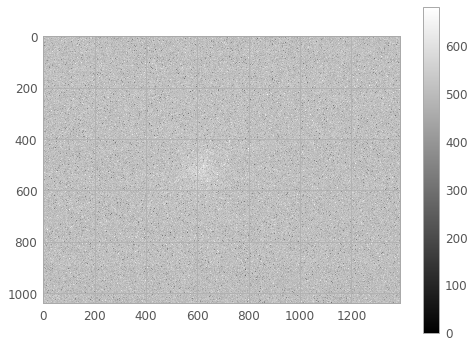

In [9]:
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

plt.style.use(astropy_mpl_style)
image_file = get_pkg_data_filename('tutorials/FITS-images/M13_blue_0005.fits')
image_data = fits.getdata(image_file, ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

plt.show()


Dibujamos la Galaxia en pantalla

## Anexo I. Definición de conceptos
* **BOSS:** Abreviatura de Baryon Oscillation Spectroscopic Survey. Catalogo de espectos de galaxias, estrellas y quasars.

Referencia para formatear Markdown: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
